In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fallas = ['NoFault', 'AB', 'BC', 'CA', 'ABC', 'AG', 'BG', 'CG']
distancias = [10, 20, 50, 75, 95]

# Creates column vector if x is row vector or list.
def col(x):
    return np.asarray(np.matrix(x)).T

# Calculates cosine distance between two vectors.
def cos_dist(u, v):
    return float(np.abs(np.dot(u, v)/(np.linalg.norm(u)*np.linalg.norm(v))))

# Creates m-by-2 matrix of data.
def create_x(alpha, beta):
    m = len(alpha)
    x = np.zeros((m, 2))

    for i in range(m):
        x[i, 0] = alpha[i]
        x[i, 1] = beta[i]

    return x

# Clarke Transform referred to phase A
def Clarke_ref_A(A, B, C):

    alpha = []
    beta = []
    z = []

    voltajes = np.zeros((3,1))
    mat_Clarke = np.array([[1, -1/2, -1/2], [0, np.sqrt(3)/2, -np.sqrt(3)/2], [1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)]])

    for i in range(len(A)):
        voltajes[0] = A[i]
        voltajes[1] = B[i]
        voltajes[2] = C[i]

        space_vec = np.sqrt(2/3)*mat_Clarke@voltajes # Si acaso cambiar por np.sqrt(2/3)

        alpha.append(space_vec[0])
        beta.append(space_vec[1])
        z.append(space_vec[2])

    return alpha, beta, z

# Clarke Transform referred to phase B
def Clarke_ref_B(B, C, A):

    alpha = []
    beta = []
    z = []

    voltajes = np.zeros((3,1))
    mat_Clarke = np.array([[1, -1/2, -1/2], [0, np.sqrt(3)/2, -np.sqrt(3)/2], [1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)]])

    for i in range(len(A)):
        voltajes[0] = B[i]
        voltajes[1] = C[i]
        voltajes[2] = A[i]

        space_vec = np.sqrt(2/3)*mat_Clarke@voltajes # Si acaso cambiar por np.sqrt(2/3)

        alpha.append(space_vec[0])
        beta.append(space_vec[1])
        z.append(space_vec[2])

    return alpha, beta, z

# Clarke Transform referred to phase C
def Clarke_ref_C(C, A, B):

    alpha = []
    beta = []
    z = []

    voltajes = np.zeros((3,1))
    mat_Clarke = np.array([[1, -1/2, -1/2], [0, np.sqrt(3)/2, -np.sqrt(3)/2], [1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)]])

    for i in range(len(A)):
        voltajes[0] = C[i]
        voltajes[1] = A[i]
        voltajes[2] = B[i]

        space_vec = np.sqrt(2/3)*mat_Clarke@voltajes # Si acaso cambiar por np.sqrt(2/3)

        alpha.append(space_vec[0])
        beta.append(space_vec[1])
        z.append(space_vec[2])

    return alpha, beta, z

# Function that fits an ellipse to a given set of data x, y. Returns a, b, c, d, e, f parameters.
def fit_ellipse(x, y):
    """
    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.

    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    
    return np.concatenate((ak, T @ ak)).ravel()

# Function to get Q, u and f parameters for each fault type
def get_ellipse_params(abcdef):

    a = abcdef[0]
    b = abcdef[1]
    c = abcdef[2]
    d = abcdef[3]
    e = abcdef[4]
    f = np.round(abcdef[5], 4)

    Q = np.round(np.array([[a, b], [b, c]]), 4)
    u = np.round(np.array([[d], [e]]), 4)

    return Q, u, f

# Function to graph ellipses in alpha-beta plane.
def graf_elipses(abcdef, step, lims_x, lims_y, alpha, beta, falla):

    a = abcdef[0]
    b = abcdef[1]
    c = abcdef[2]
    d = abcdef[3]
    e = abcdef[4]
    f = abcdef[5]

    Q = np.array([[a, b], [b, c]])
    u = np.array([[d], [e]])
    x = np.arange(-lims_x, lims_x, step)
    y = np.arange(-lims_y, lims_y, step)

    valsA, vectsA = np.linalg.eig(Q)

    eigVcA1 = np.abs(valsA[0])*vectsA[:,0]
    eigVcA2 = np.abs(valsA[1])*vectsA[:,1]

    X, Y = np.meshgrid(x, y)

    # Z es la forma cuadrática asociada a la matriz
    Z = Q[0,0]*X**2 + (Q[0,1] + Q[1,0])*X*Y + Q[1,1]*Y**2 + d*X + e*Y

    fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
    CS = ax[0].contour(X, Y, Z, [-f], colors=('r'))
    CS = ax[2].contour(X, Y, Z, [-f], colors=('r'))
            
    ax[0].clabel(CS, inline=True, fontsize=10)
    ax[0].quiver(0, 0, eigVcA1[0], eigVcA1[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].quiver(0, 0, eigVcA2[0], eigVcA2[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].grid()
    ax[0].set_xlabel(r'$V_\alpha$', fontsize=18)
    ax[0].set_ylabel(r'$V_\beta$', fontsize=18)
    ax[0].set_title(f'Elipse de mejor ajuste\n{np.round(Q[0,0], 4)}'+r'$V_{\alpha}^2$' + f' + {np.round(Q[0,1] + Q[1,0], 4)}' + r'$V_{\alpha}V_{\beta}$' + f' + {np.round(Q[1,1], 4)}' + r'$V_{\beta}^2$' + f' \n+ {np.round(d, 4)}' + r'$V_{\alpha}$' + f' + {np.round(e, 4)}' + r'$V_{\beta}$ + ' + f'{np.round(f, 4):,}' + ' = 0')

    ax[1].scatter(alpha, beta, label=falla)
    ax[1].legend(fontsize=14)
    ax[1].grid()
    ax[1].set_xlabel(r'$V_\alpha$', fontsize=18)
    ax[1].set_ylabel(r'$V_\beta$', fontsize=18)
    ax[1].set_title(r'Transformada de Clarke (elipse real)', fontsize=18)
            
    ax[2].clabel(CS, inline=True, fontsize=10)
    ax[2].quiver(0, 0, eigVcA1[0], eigVcA1[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[2].quiver(0, 0, eigVcA2[0], eigVcA2[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[2].grid()
    ax[2].scatter(alpha, beta, label=falla)
    ax[2].legend(fontsize=14)
    ax[2].set_xlabel(r'$V_\alpha$', fontsize=18)
    ax[2].set_ylabel(r'$V_\beta$', fontsize=18)
    ax[2].set_title('Elipse real con elipse de mejor ajuste', fontsize=18)
    fig.tight_layout()

    plt.savefig(f'una_ventana/grafs_y_cms/espa/elipses_{falla}.eps', format='eps')

    return Q, u, float(f)

# Function to compare ellipses in alpha-beta plane.
def compare_elipses(abcdefs1, abcdefs2, step, lims_x, lims_y, alphas1, betas1, alphas2, betas2, falla1, falla2, error):
    
    # alphas y betas son listas con los vectores alpha y beta de cada referencia de Clarke
    alpha1_A = alphas1[0]
    alpha1_B = alphas1[1]
    alpha1_C = alphas1[2]

    beta1_A = betas1[0]
    beta1_B = betas1[1]
    beta1_C = betas1[2]
    
    alpha2_A = alphas2[0]
    alpha2_B = alphas2[1]
    alpha2_C = alphas2[2]

    beta2_A = betas2[0]
    beta2_B = betas2[1]
    beta2_C = betas2[2]

    # abcdefs es una lista con los abcdef de cada referencia de Clarke
    abcdef1_A = abcdefs1[0]
    abcdef1_B = abcdefs1[1]
    abcdef1_C = abcdefs1[2]

    abcdef2_A = abcdefs2[0]
    abcdef2_B = abcdefs2[1]
    abcdef2_C = abcdefs2[2]

    a1_A = abcdef1_A[0]
    b1_A = abcdef1_A[1]
    c1_A = abcdef1_A[2]
    d1_A = abcdef1_A[3]
    e1_A = abcdef1_A[4]
    f1_A = abcdef1_A[5]

    a1_B = abcdef1_B[0]
    b1_B = abcdef1_B[1]
    c1_B = abcdef1_B[2]
    d1_B = abcdef1_B[3]
    e1_B = abcdef1_B[4]
    f1_B = abcdef1_B[5]

    a1_C = abcdef1_C[0]
    b1_C = abcdef1_C[1]
    c1_C = abcdef1_C[2]
    d1_C = abcdef1_C[3]
    e1_C = abcdef1_C[4]
    f1_C = abcdef1_C[5]

    a2_A = abcdef2_A[0]
    b2_A = abcdef2_A[1]
    c2_A = abcdef2_A[2]
    d2_A = abcdef2_A[3]
    e2_A = abcdef2_A[4]
    f2_A = abcdef2_A[5]

    a2_B = abcdef2_B[0]
    b2_B = abcdef2_B[1]
    c2_B = abcdef2_B[2]
    d2_B = abcdef2_B[3]
    e2_B = abcdef2_B[4]
    f2_B = abcdef2_B[5]

    a2_C = abcdef2_C[0]
    b2_C = abcdef2_C[1]
    c2_C = abcdef2_C[2]
    d2_C = abcdef2_C[3]
    e2_C = abcdef2_C[4]
    f2_C = abcdef2_C[5]

    Q1_A = np.array([[a1_A, b1_A], [b1_A, c1_A]])
    Q1_B = np.array([[a1_B, b1_B], [b1_B, c1_B]])
    Q1_C = np.array([[a1_C, b1_C], [b1_C, c1_C]])

    Q2_A = np.array([[a2_A, b2_A], [b2_A, c2_A]])
    Q2_B = np.array([[a2_B, b2_B], [b2_B, c2_B]])
    Q2_C = np.array([[a2_C, b2_C], [b2_C, c2_C]])

    x = np.arange(-lims_x, lims_x, step)
    y = np.arange(-lims_y, lims_y, step)

    valsQ1_A, vectsQ1_A = np.linalg.eig(Q1_A)
    valsQ1_B, vectsQ1_B = np.linalg.eig(Q1_B)
    valsQ1_C, vectsQ1_C = np.linalg.eig(Q1_C)

    valsQ2_A, vectsQ2_A = np.linalg.eig(Q2_A)
    valsQ2_B, vectsQ2_B = np.linalg.eig(Q2_B)
    valsQ2_C, vectsQ2_C = np.linalg.eig(Q2_C)

    eigVcQ11_A = np.linalg.norm(valsQ1_A[0])*vectsQ1_A[:,0]
    eigVcQ12_A = np.linalg.norm(valsQ1_A[1])*vectsQ1_A[:,1]
    
    eigVcQ21_A = np.linalg.norm(valsQ2_A[0])*vectsQ2_A[:,0]
    eigVcQ22_A = np.linalg.norm(valsQ2_A[1])*vectsQ2_A[:,1]

    eigVcQ11_B = np.linalg.norm(valsQ1_B[0])*vectsQ1_B[:,0]
    eigVcQ12_B = np.linalg.norm(valsQ1_B[1])*vectsQ1_B[:,1]
    
    eigVcQ21_B = np.linalg.norm(valsQ2_B[0])*vectsQ2_B[:,0]
    eigVcQ22_B = np.linalg.norm(valsQ2_B[1])*vectsQ2_B[:,1]

    eigVcQ11_C = np.linalg.norm(valsQ1_C[0])*vectsQ1_C[:,0]
    eigVcQ12_C = np.linalg.norm(valsQ1_C[1])*vectsQ1_C[:,1]
    
    eigVcQ21_C = np.linalg.norm(valsQ2_C[0])*vectsQ2_C[:,0]
    eigVcQ22_C = np.linalg.norm(valsQ2_C[1])*vectsQ2_C[:,1]

    X, Y = np.meshgrid(x, y)

    # Z es la forma cuadrática asociada a la matriz
    Z1_A = Q1_A[0,0]*X**2 + (Q1_A[0,1] + Q1_A[1,0])*X*Y + Q1_A[1,1]*Y**2 + d1_A*X + e1_A*Y
    Z2_A = Q2_A[0,0]*X**2 + (Q2_A[0,1] + Q2_A[1,0])*X*Y + Q2_A[1,1]*Y**2 + d2_A*X + e2_A*Y
    
    Z1_B = Q1_B[0,0]*X**2 + (Q1_B[0,1] + Q1_B[1,0])*X*Y + Q1_B[1,1]*Y**2 + d1_B*X + e1_B*Y
    Z2_B = Q2_B[0,0]*X**2 + (Q2_B[0,1] + Q2_B[1,0])*X*Y + Q2_B[1,1]*Y**2 + d2_B*X + e2_B*Y

    Z1_C = Q1_C[0,0]*X**2 + (Q1_C[0,1] + Q1_C[1,0])*X*Y + Q1_C[1,1]*Y**2 + d1_C*X + e1_C*Y
    Z2_C = Q2_C[0,0]*X**2 + (Q2_C[0,1] + Q2_C[1,0])*X*Y + Q2_C[1,1]*Y**2 + d2_C*X + e2_C*Y

    fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
    CS1_A = ax[0].contour(X, Y, Z1_A, [-f1_A], colors=('b'))
    CS2_A = ax[0].contour(X, Y, Z2_A, [-f2_A], colors=('r'))
    
    CS1_B = ax[1].contour(X, Y, Z1_B, [-f1_B], colors=('b'))
    CS2_B = ax[1].contour(X, Y, Z2_B, [-f2_B], colors=('r'))

    CS1_C = ax[2].contour(X, Y, Z1_C, [-f1_C], colors=('b'))
    CS2_C = ax[2].contour(X, Y, Z2_C, [-f2_C], colors=('r'))
            
    ax[0].clabel(CS1_A, inline=True, fontsize=10)
    ax[0].clabel(CS2_A, inline=True, fontsize=10)
    ax[0].scatter(alpha1_A, beta1_A, label=falla1)
    ax[0].scatter(alpha2_A, beta2_A, label=falla2)
    ax[0].quiver(0, 0, eigVcQ11_A[0], eigVcQ11_A[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax[0].quiver(0, 0, eigVcQ12_A[0], eigVcQ12_A[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax[0].quiver(0, 0, eigVcQ21_A[0], eigVcQ21_A[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].quiver(0, 0, eigVcQ22_A[0], eigVcQ22_A[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].legend(fontsize=14)
    ax[0].grid()
    ax[0].set_xlabel(r'$V_\alpha$', fontsize=18)
    ax[0].set_ylabel(r'$V_\beta$', fontsize=18)
    ax[0].set_title(r'Transformada de Clarke (RefA)', fontsize=18)
            
    ax[1].clabel(CS1_B, inline=True, fontsize=10)
    ax[1].clabel(CS2_B, inline=True, fontsize=10)
    ax[1].scatter(alpha1_B, beta1_B, label=falla1)
    ax[1].scatter(alpha2_B, beta2_B, label=falla2)
    ax[1].quiver(0, 0, eigVcQ11_B[0], eigVcQ11_B[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax[1].quiver(0, 0, eigVcQ12_B[0], eigVcQ12_B[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax[1].quiver(0, 0, eigVcQ21_B[0], eigVcQ21_B[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[1].quiver(0, 0, eigVcQ22_B[0], eigVcQ22_B[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[1].legend(fontsize=14)
    ax[1].grid()
    ax[1].set_xlabel(r'$V_\alpha$', fontsize=18)
    ax[1].set_ylabel(r'$V_\beta$', fontsize=18)
    ax[1].set_title(r'Transformada de Clarke (RefB)', fontsize=18)
            
    ax[2].clabel(CS1_C, inline=True, fontsize=10)
    ax[2].clabel(CS2_C, inline=True, fontsize=10)
    ax[2].scatter(alpha1_C, beta1_C, label=falla1)
    ax[2].scatter(alpha2_C, beta2_C, label=falla2)
    ax[2].quiver(0, 0, eigVcQ11_C[0], eigVcQ11_C[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax[2].quiver(0, 0, eigVcQ12_C[0], eigVcQ12_C[1], angles='xy', scale_units='xy', scale=1, color='b')
    ax[2].quiver(0, 0, eigVcQ21_C[0], eigVcQ21_C[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[2].quiver(0, 0, eigVcQ22_C[0], eigVcQ22_C[1], angles='xy', scale_units='xy', scale=1, color='r')
    ax[2].legend(fontsize=14)
    ax[2].grid()
    ax[2].set_xlabel(r'$V_\alpha$', fontsize=18)
    ax[2].set_ylabel(r'$V_\beta$', fontsize=18)
    ax[2].set_title(r'Transformada de Clarke (RefC)', fontsize=18)
    fig.tight_layout()

    if error == True:
        plt.savefig(f'una_ventana/grafs_y_cms/espa/comp_elipses_error.eps', format='eps')
    else:
        plt.savefig(f'una_ventana/grafs_y_cms/espa/comp_elipses_exito.eps', format='eps')

# Function to graph same fault ellipse for different distances.
def graph_ellipses_distance(abcdefs, step, lims_x, lims_y, falla):
    # lims_x y lims_y son listas con los límites respectivos para cada distancia

    # abcdefs es una lista con los abcdef de cada distancia
    abcdef_10 = abcdefs[0]
    abcdef_20 = abcdefs[1]
    abcdef_50 = abcdefs[2]
    abcdef_75 = abcdefs[3]
    abcdef_95 = abcdefs[4]

    a_10 = abcdef_10[0]
    b_10 = abcdef_10[1]
    c_10 = abcdef_10[2]
    d_10 = abcdef_10[3]
    e_10 = abcdef_10[4]
    f_10 = abcdef_10[5]

    a_20 = abcdef_20[0]
    b_20 = abcdef_20[1]
    c_20 = abcdef_20[2]
    d_20 = abcdef_20[3]
    e_20 = abcdef_20[4]
    f_20 = abcdef_20[5]

    a_50 = abcdef_50[0]
    b_50 = abcdef_50[1]
    c_50 = abcdef_50[2]
    d_50 = abcdef_50[3]
    e_50 = abcdef_50[4]
    f_50 = abcdef_50[5]

    a_75 = abcdef_75[0]
    b_75 = abcdef_75[1]
    c_75 = abcdef_75[2]
    d_75 = abcdef_75[3]
    e_75 = abcdef_75[4]
    f_75 = abcdef_75[5]

    a_95 = abcdef_95[0]
    b_95 = abcdef_95[1]
    c_95 = abcdef_95[2]
    d_95 = abcdef_95[3]
    e_95 = abcdef_95[4]
    f_95 = abcdef_95[5]

    Q_10 = np.array([[a_10, b_10], [b_10, c_10]])
    Q_20 = np.array([[a_20, b_20], [b_20, c_20]])
    Q_50 = np.array([[a_50, b_50], [b_50, c_50]])
    Q_75 = np.array([[a_75, b_75], [b_75, c_75]])
    Q_95 = np.array([[a_95, b_95], [b_95, c_95]])

    x_10 = np.arange(-lims_x[0], lims_x[0], step)
    y_10 = np.arange(-lims_y[0], lims_y[0], step)

    x_20 = np.arange(-lims_x[1], lims_x[1], step)
    y_20 = np.arange(-lims_y[1], lims_y[1], step)

    x_50 = np.arange(-lims_x[2], lims_x[2], step)
    y_50 = np.arange(-lims_y[2], lims_y[2], step)

    x_75 = np.arange(-lims_x[3], lims_x[3], step)
    y_75 = np.arange(-lims_y[3], lims_y[3], step)

    x_95 = np.arange(-lims_x[4], lims_x[4], step)
    y_95 = np.arange(-lims_y[4], lims_y[4], step)
    
    X_10, Y_10 = np.meshgrid(x_10, y_10)
    X_20, Y_20 = np.meshgrid(x_20, y_20)
    X_50, Y_50 = np.meshgrid(x_50, y_50)
    X_75, Y_75 = np.meshgrid(x_75, y_75)
    X_95, Y_95 = np.meshgrid(x_95, y_95)
    
    # Z es la forma cuadrática asociada a la matriz
    Z_10 = Q_10[0,0]*X_10**2 + (Q_10[0,1] + Q_10[1,0])*X_10*Y_10 + Q_10[1,1]*Y_10**2 + d_10*X_10 + e_10*Y_10
    Z_20 = Q_20[0,0]*X_20**2 + (Q_20[0,1] + Q_20[1,0])*X_20*Y_20 + Q_20[1,1]*Y_20**2 + d_20*X_20 + e_20*Y_20
    Z_50 = Q_50[0,0]*X_50**2 + (Q_50[0,1] + Q_50[1,0])*X_50*Y_50 + Q_50[1,1]*Y_50**2 + d_50*X_50 + e_50*Y_50
    Z_75 = Q_75[0,0]*X_75**2 + (Q_75[0,1] + Q_75[1,0])*X_75*Y_75 + Q_75[1,1]*Y_75**2 + d_75*X_75 + e_75*Y_75
    Z_95 = Q_95[0,0]*X_95**2 + (Q_95[0,1] + Q_95[1,0])*X_95*Y_95 + Q_95[1,1]*Y_95**2 + d_95*X_95 + e_95*Y_95

    plt.figure(figsize=(6,6))
    CS_10 = plt.contour(X_10, Y_10, Z_10, [-f_10], colors=('r'))
    CS_20 = plt.contour(X_20, Y_20, Z_20, [-f_20], colors=('g'))
    CS_50 = plt.contour(X_50, Y_50, Z_50, [-f_50], colors=('b'))
    CS_75 = plt.contour(X_75, Y_75, Z_75, [-f_75], colors=('c'))
    CS_95 = plt.contour(X_95, Y_95, Z_95, [-f_95], colors=('m'))

    plt.clabel(CS_10, inline=True, fontsize=10)
    plt.clabel(CS_20, inline=True, fontsize=10)
    plt.clabel(CS_50, inline=True, fontsize=10)
    plt.clabel(CS_75, inline=True, fontsize=10)
    plt.clabel(CS_95, inline=True, fontsize=10)
    CS_10.collections[0].set_label('10km')
    CS_20.collections[0].set_label('20km')
    CS_50.collections[0].set_label('50km')
    CS_75.collections[0].set_label('75km')
    CS_95.collections[0].set_label('95km')
    plt.legend(fontsize=14, loc='upper right')
    plt.grid()
    plt.xlabel(r'$V_\alpha$', fontsize=18)
    plt.ylabel(r'$V_\beta$', fontsize=18)
    plt.title(f'Transformada de Clarke ({falla})', fontsize=18)
    plt.savefig(f'una_ventana/grafs_y_cms/espa/elipses{falla}_por_distancias.eps', format='eps')

# Voltajes contra el tiempo por falla (10km_2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


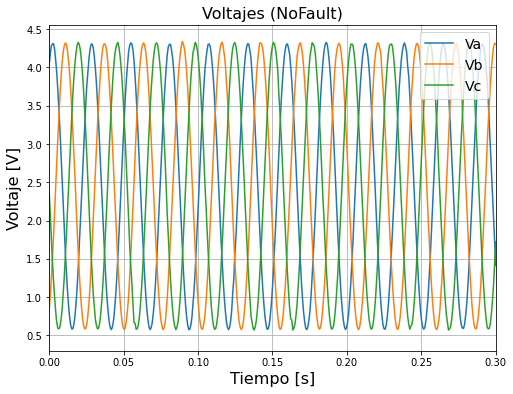

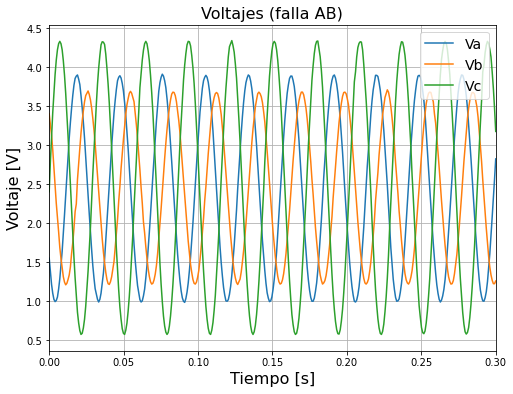

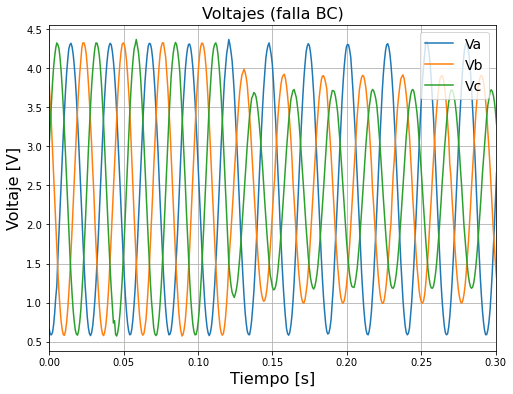

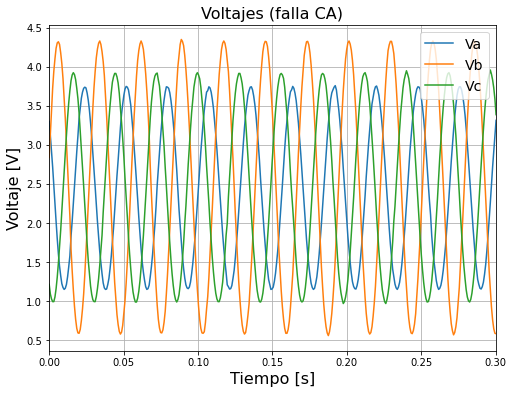

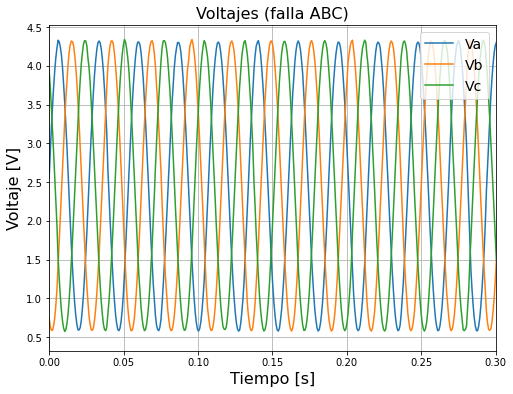

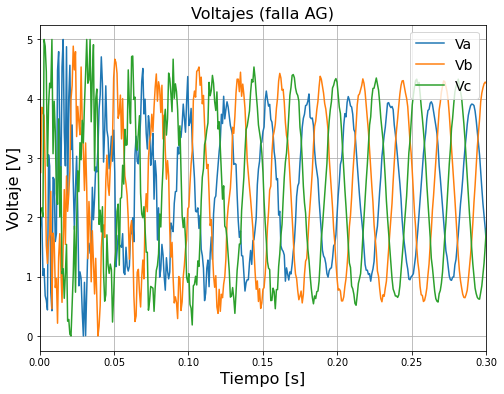

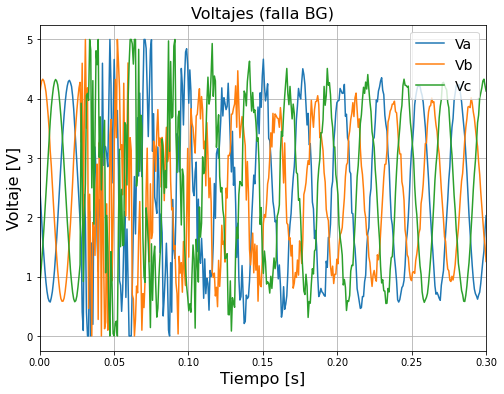

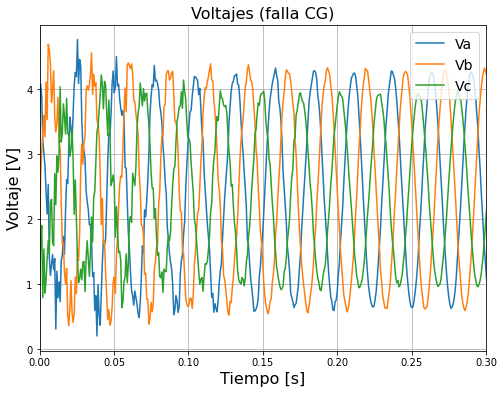

In [29]:
for falla in fallas:

    v = pd.read_excel(f'datos_train/{falla}/voltajes_{falla}_10km_2.xlsx')
    Va = v['Va'].values
    Vb = v['Vb'].values
    Vc = v['Vc'].values

    t = np.linspace(0, 3, len(Va))

    plt.figure(figsize=(8,6))
    plt.plot(t, Va, label='Va')
    plt.plot(t, Vb, label='Vb')
    plt.plot(t, Vc, label='Vc')
    if falla=='NoFault':
        plt.title(f'Voltajes ({falla})', fontsize=16)
    else:
        plt.title(f'Voltajes (falla {falla})', fontsize=16)
    plt.xlabel('Tiempo [s]', fontsize=16)
    plt.ylabel('Voltaje [V]', fontsize=16)
    plt.legend(fontsize=14, loc='upper right')
    plt.grid()
    plt.xlim([0, 0.3])
    plt.savefig(f'una_ventana/grafs_y_cms/espa/voltajes_{falla}.eps', format='eps')

# Elipses por falla (10km_4)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


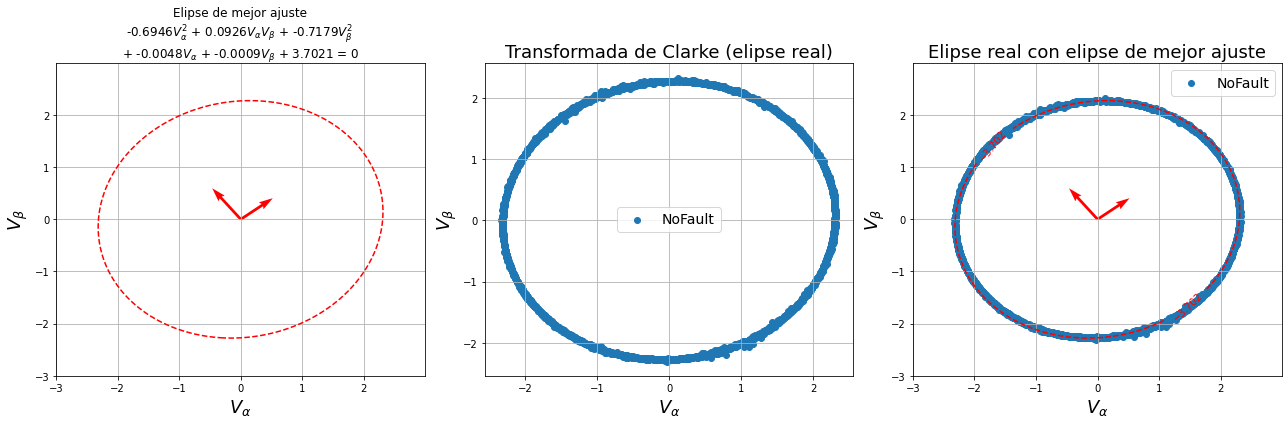

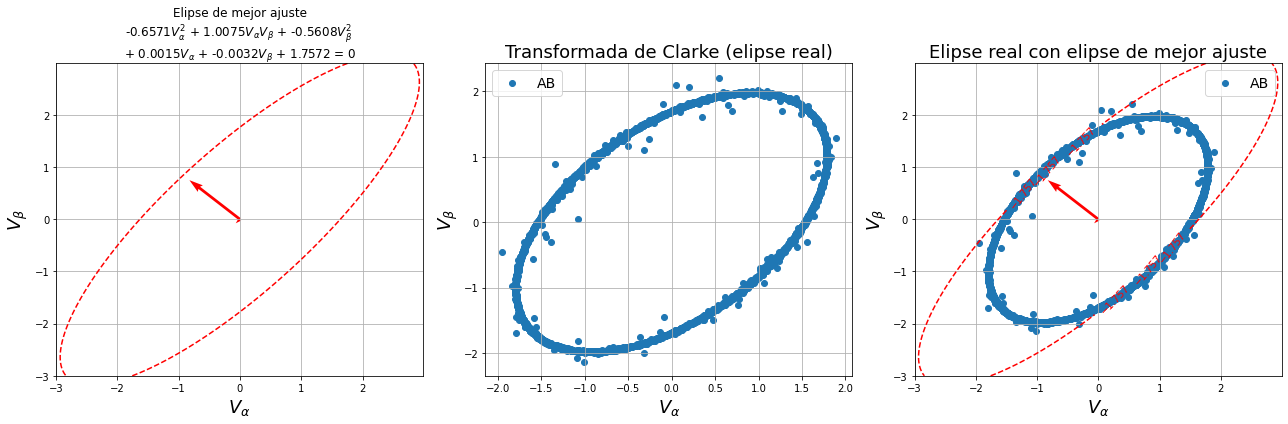

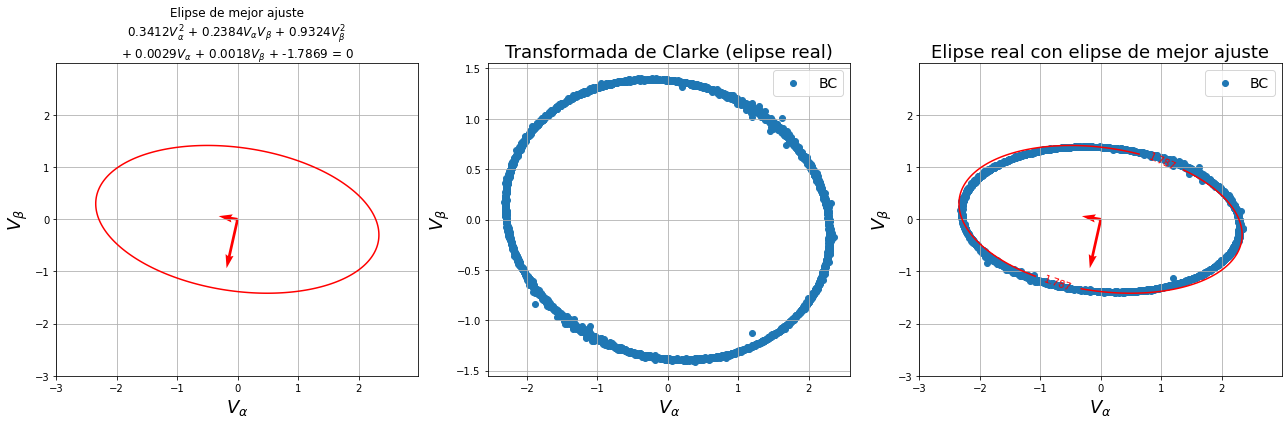

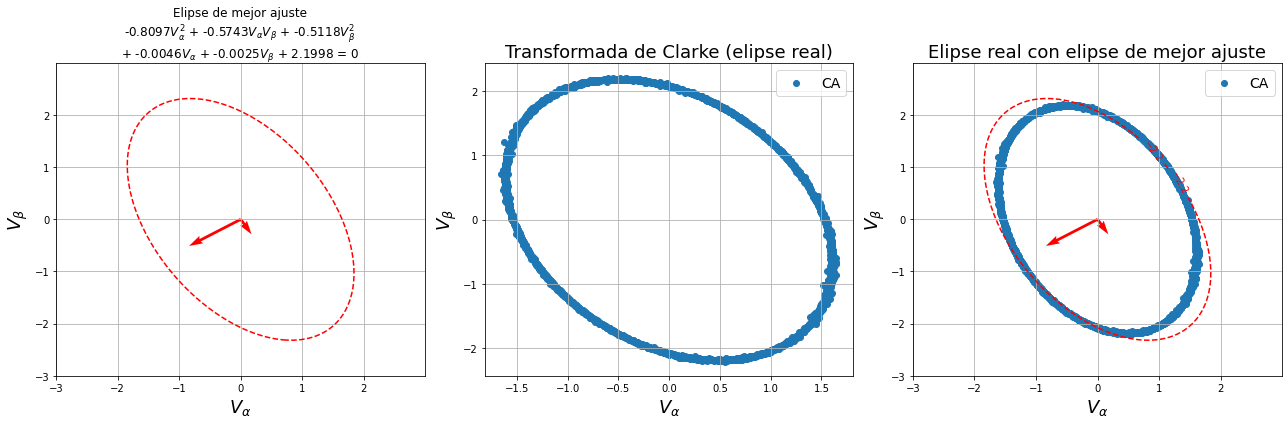

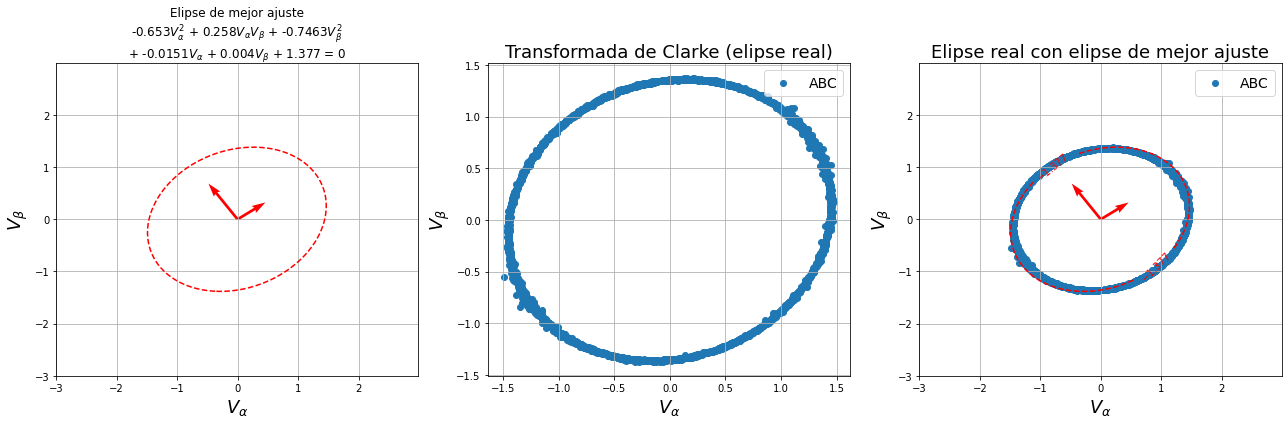

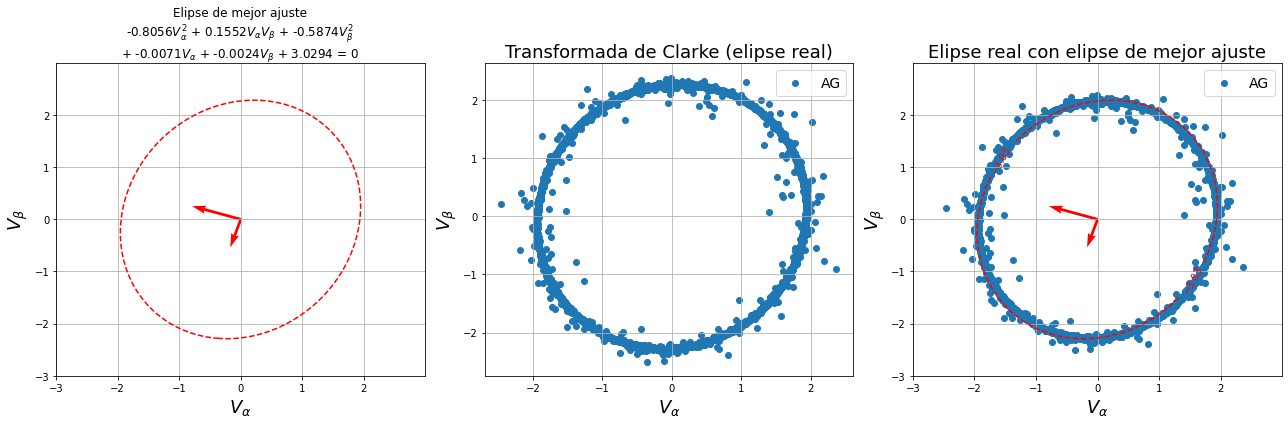

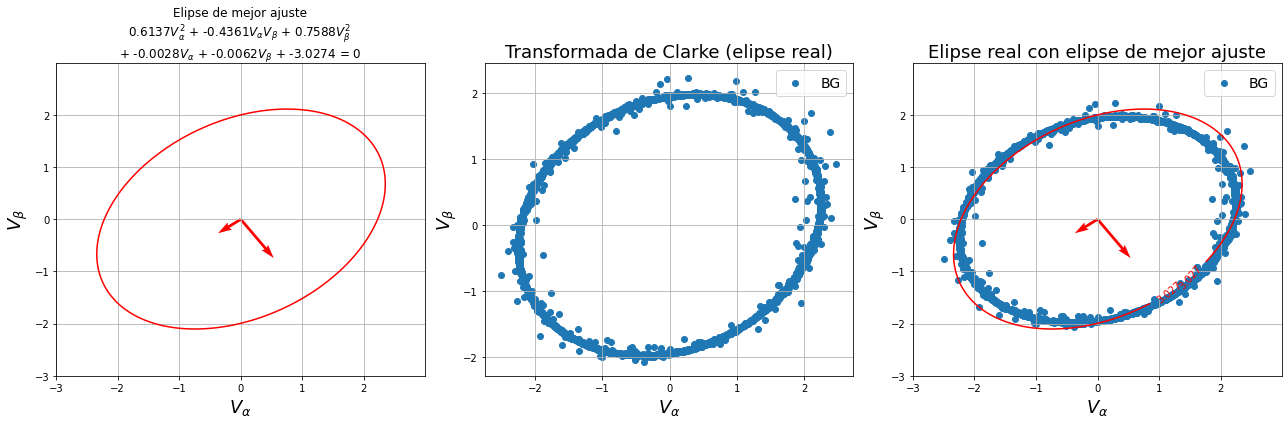

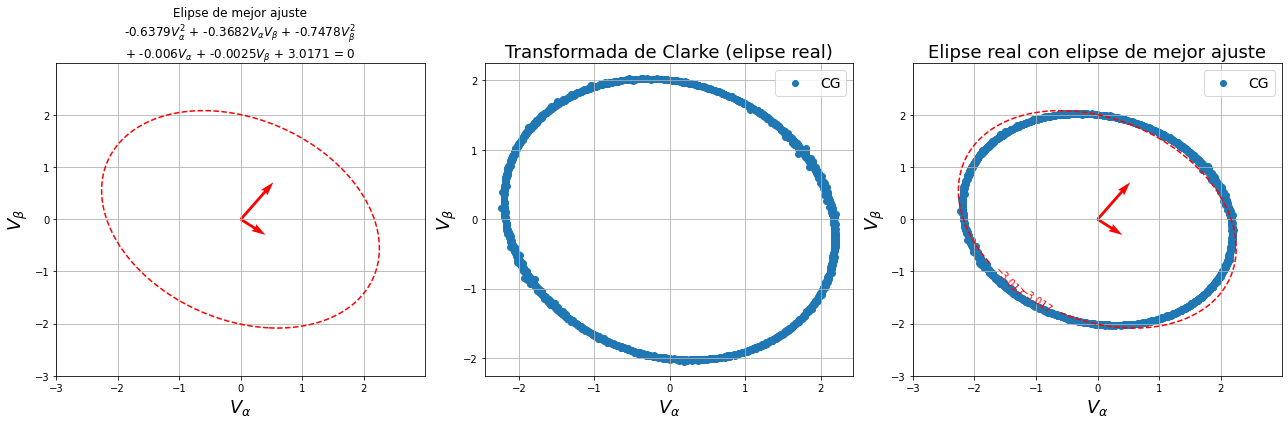

In [30]:
for falla in fallas:
    v = pd.read_excel(f'datos_train/{falla}/voltajes_{falla}_10km_4.xlsx')
    Va = v['Va'].values
    Vb = v['Vb'].values
    Vc = v['Vc'].values

    # Clarke Transforms
    alpha_refA, beta_refA, z_refA = Clarke_ref_A(Va, Vb, Vc)
    alpha_refB, beta_refB, z_refB = Clarke_ref_B(Vb, Vc, Va)
    alpha_refC, beta_refC, z_refC = Clarke_ref_C(Vc, Va, Vb)

    # Create 2xm matrices
    x_refA = create_x(alpha_refA, beta_refA)
    x_refB = create_x(alpha_refB, beta_refB)
    x_refC = create_x(alpha_refC, beta_refC)

    # Ellipse fitting
    abcdef_refA = fit_ellipse(x_refA[:,0], x_refA[:,1])
    abcdef_refB = fit_ellipse(x_refB[:,0], x_refB[:,1])
    abcdef_refC = fit_ellipse(x_refC[:,0], x_refC[:,1])

    # Graphs
    if falla=='AB':
        graf_elipses(abcdef_refA, 0.01, 3, 3, alpha_refA[200:], beta_refA[200:], falla)
    elif falla=='CA' or falla=='BG' or falla=='ABC':
        graf_elipses(abcdef_refA, 0.01, 3, 3, alpha_refA[500:], beta_refA[500:], falla)
    else:
        graf_elipses(abcdef_refA, 0.01, 3, 3, alpha_refA, beta_refA, falla)

# Elipses de una misma falla para diferentes distancias (solo refA)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


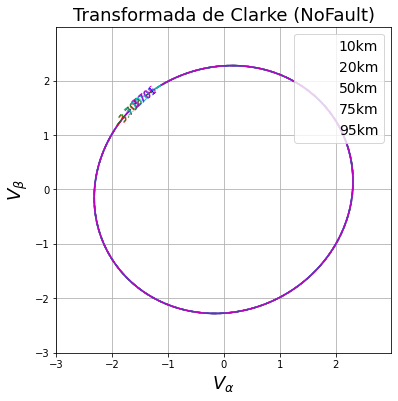

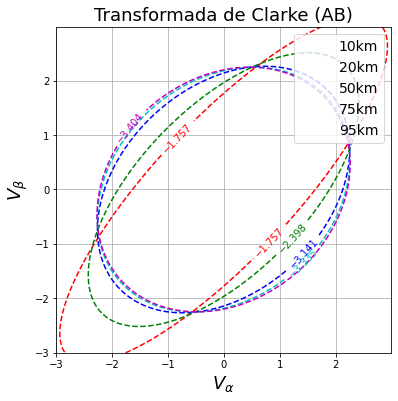

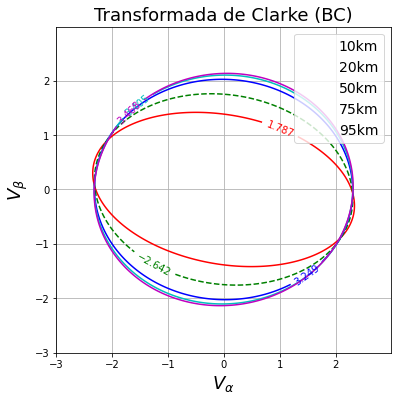

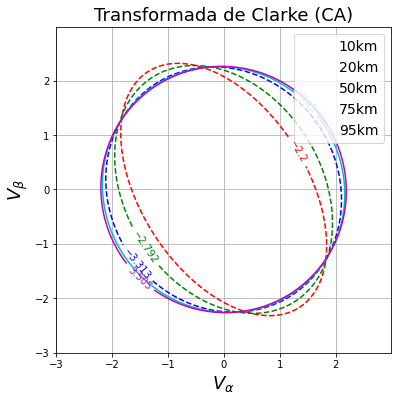

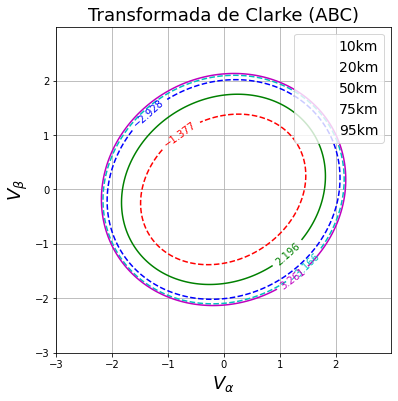

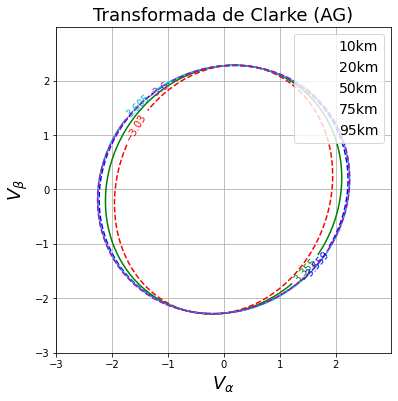

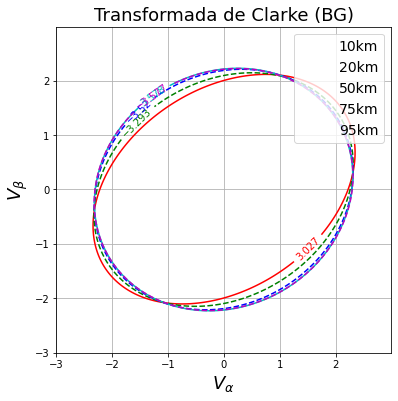

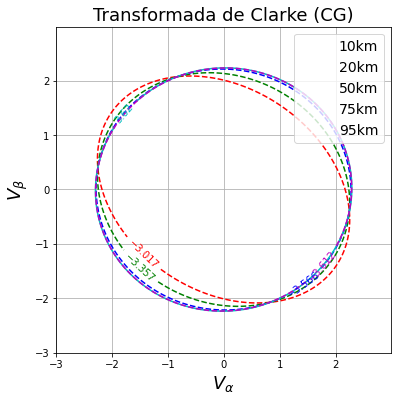

In [31]:
for falla in fallas:
    abcdefs = []
    alphas = []
    betas = []
    lims_x = [3, 3, 3, 3, 3]
    lims_y = [3, 3, 3, 3, 3]

    for dist in distancias:
        v = pd.read_excel(f'datos_train/{falla}/voltajes_{falla}_{dist}km_4.xlsx')
        Va = v['Va'].values
        Vb = v['Vb'].values
        Vc = v['Vc'].values

        # Clarke Transforms
        alpha_refA, beta_refA, z_refA = Clarke_ref_A(Va, Vb, Vc)

        # Create 2xm matrices
        x_refA = create_x(alpha_refA, beta_refA)

        # Ellipse fitting
        abcdef_refA = fit_ellipse(x_refA[:,0], x_refA[:,1])

        abcdefs.append(abcdef_refA)
        alphas.append(alpha_refA)
        betas.append(beta_refA)

    graph_ellipses_distance(abcdefs, 0.01, lims_x, lims_y, falla)

# Caso de éxito

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


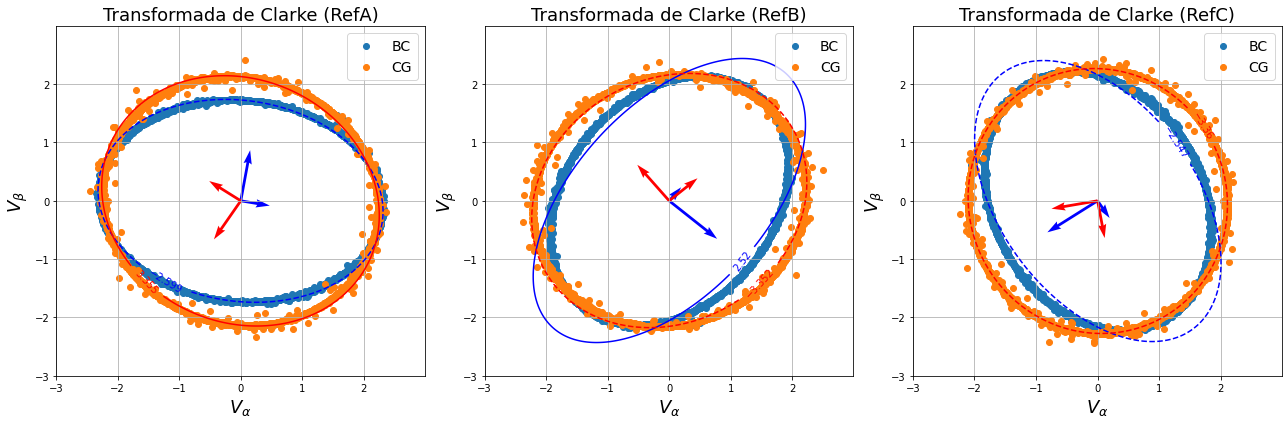

In [32]:
BC_suc = pd.read_excel(f'datos_train/BC/voltajes_BC_20km_0.xlsx')
Va_BC_suc = BC_suc['Va'].values
Vb_BC_suc = BC_suc['Vb'].values
Vc_BC_suc = BC_suc['Vc'].values

CG_suc = pd.read_excel(f'datos_train/CG/voltajes_CG_20km_0.xlsx')
Va_CG_suc = CG_suc['Va'].values
Vb_CG_suc = CG_suc['Vb'].values
Vc_CG_suc = CG_suc['Vc'].values

# Clarke Transforms
alpha_refA_BC_suc, beta_refA_BC_suc, z_refA_BC_suc = Clarke_ref_A(Va_BC_suc, Vb_BC_suc, Vc_BC_suc)
alpha_refB_BC_suc, beta_refB_BC_suc, z_refB_BC_suc = Clarke_ref_B(Vb_BC_suc, Vc_BC_suc, Va_BC_suc)
alpha_refC_BC_suc, beta_refC_BC_suc, z_refC_BC_suc = Clarke_ref_C(Vc_BC_suc, Va_BC_suc, Vb_BC_suc)

alpha_refA_CG_suc, beta_refA_CG_suc, z_refA_CG_suc = Clarke_ref_A(Va_CG_suc, Vb_CG_suc, Vc_CG_suc)
alpha_refB_CG_suc, beta_refB_CG_suc, z_refB_CG_suc = Clarke_ref_B(Vb_CG_suc, Vc_CG_suc, Va_CG_suc)
alpha_refC_CG_suc, beta_refC_CG_suc, z_refC_CG_suc = Clarke_ref_C(Vc_CG_suc, Va_CG_suc, Vb_CG_suc)

# Create 2xm matrices
x_refA_BC_suc = create_x(alpha_refA_BC_suc, beta_refA_BC_suc)
x_refB_BC_suc = create_x(alpha_refB_BC_suc, beta_refB_BC_suc)
x_refC_BC_suc = create_x(alpha_refC_BC_suc, beta_refC_BC_suc)

x_refA_CG_suc = create_x(alpha_refA_CG_suc, beta_refA_CG_suc)
x_refB_CG_suc = create_x(alpha_refB_CG_suc, beta_refB_CG_suc)
x_refC_CG_suc = create_x(alpha_refC_CG_suc, beta_refC_CG_suc)

# Ellipse fitting
abcdef_refA_BC_suc = fit_ellipse(x_refA_BC_suc[:,0], x_refA_BC_suc[:,1])
abcdef_refB_BC_suc = fit_ellipse(x_refB_BC_suc[:,0], x_refB_BC_suc[:,1])
abcdef_refC_BC_suc = fit_ellipse(x_refC_BC_suc[:,0], x_refC_BC_suc[:,1])

abcdef_refA_CG_suc = fit_ellipse(x_refA_CG_suc[:,0], x_refA_CG_suc[:,1])
abcdef_refB_CG_suc = fit_ellipse(x_refB_CG_suc[:,0], x_refB_CG_suc[:,1])
abcdef_refC_CG_suc = fit_ellipse(x_refC_CG_suc[:,0], x_refC_CG_suc[:,1])

abcdefs_BC_suc = [abcdef_refA_BC_suc, abcdef_refB_BC_suc, abcdef_refC_BC_suc]
abcdefs_CG_suc = [abcdef_refA_CG_suc, abcdef_refB_CG_suc, abcdef_refC_CG_suc]

alphas_BC_suc = [alpha_refA_BC_suc, alpha_refB_BC_suc, alpha_refC_BC_suc]
betas_BC_suc = [beta_refA_BC_suc, beta_refB_BC_suc, beta_refC_BC_suc]

alphas_CG_suc = [alpha_refA_CG_suc, alpha_refB_CG_suc, alpha_refC_CG_suc]
betas_CG_suc = [beta_refA_CG_suc, beta_refB_CG_suc, beta_refC_CG_suc]

# Graphs
compare_elipses(abcdefs_BC_suc, abcdefs_CG_suc, 0.01, 3, 3, alphas_BC_suc, betas_BC_suc, alphas_CG_suc, betas_CG_suc, 'BC', 'CG', False)

In [33]:
QBCexito_refA, uBCexito_refA, fBCexito_refA = get_ellipse_params(abcdef_refA_BC_suc)
QCGexito_refA, uCGexito_refA, fCGexito_refA = get_ellipse_params(abcdef_refA_CG_suc)

valsBCexito_refA, vectsBCexito_refA = np.linalg.eig(QBCexito_refA)
valsCGexito_refA, vectsCGexito_refA = np.linalg.eig(QCGexito_refA)

print('--------------')
print('BC_exito')
print(col(vectsBCexito_refA[:,0]))
print('---------------\nCG_exito')
print(col(vectsCGexito_refA[:,0]))
print('---------------\ncos_dist_exito')
print(np.round(cos_dist(vectsBCexito_refA[:,0], vectsCGexito_refA[:,0]), 5))

--------------
BC_exito
[[ 0.98497656]
 [-0.17268811]]
---------------
CG_exito
[[-0.8348819 ]
 [ 0.55042912]]
---------------
cos_dist_exito
0.91739


# Caso de error

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


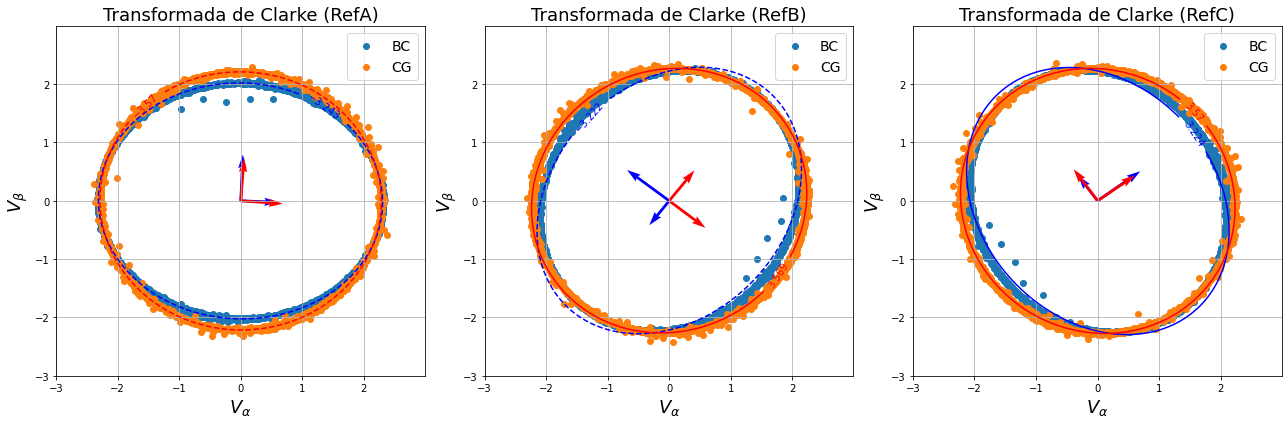

In [34]:

BC_err = pd.read_excel(f'datos_train/BC/voltajes_BC_50km_0.xlsx')
Va_BC_err = BC_err['Va'].values
Vb_BC_err = BC_err['Vb'].values
Vc_BC_err = BC_err['Vc'].values

CG_err = pd.read_excel(f'datos_train/CG/voltajes_CG_50km_0.xlsx')
Va_CG_err = CG_err['Va'].values
Vb_CG_err = CG_err['Vb'].values
Vc_CG_err = CG_err['Vc'].values

# Clarke Transforms
alpha_refA_BC_err, beta_refA_BC_err, z_refA_BC_err = Clarke_ref_A(Va_BC_err, Vb_BC_err, Vc_BC_err)
alpha_refB_BC_err, beta_refB_BC_err, z_refB_BC_err = Clarke_ref_B(Vb_BC_err, Vc_BC_err, Va_BC_err)
alpha_refC_BC_err, beta_refC_BC_err, z_refC_BC_err = Clarke_ref_C(Vc_BC_err, Va_BC_err, Vb_BC_err)

alpha_refA_CG_err, beta_refA_CG_err, z_refA_CG_err = Clarke_ref_A(Va_CG_err, Vb_CG_err, Vc_CG_err)
alpha_refB_CG_err, beta_refB_CG_err, z_refB_CG_err = Clarke_ref_B(Vb_CG_err, Vc_CG_err, Va_CG_err)
alpha_refC_CG_err, beta_refC_CG_err, z_refC_CG_err = Clarke_ref_C(Vc_CG_err, Va_CG_err, Vb_CG_err)

# Create 2xm matrices
x_refA_BC_err = create_x(alpha_refA_BC_err, beta_refA_BC_err)
x_refB_BC_err = create_x(alpha_refB_BC_err, beta_refB_BC_err)
x_refC_BC_err = create_x(alpha_refC_BC_err, beta_refC_BC_err)

x_refA_CG_err = create_x(alpha_refA_CG_err, beta_refA_CG_err)
x_refB_CG_err = create_x(alpha_refB_CG_err, beta_refB_CG_err)
x_refC_CG_err = create_x(alpha_refC_CG_err, beta_refC_CG_err)

# Ellipse fitting
abcdef_refA_BC_err = fit_ellipse(x_refA_BC_err[:,0], x_refA_BC_err[:,1])
abcdef_refB_BC_err = fit_ellipse(x_refB_BC_err[:,0], x_refB_BC_err[:,1])
abcdef_refC_BC_err = fit_ellipse(x_refC_BC_err[:,0], x_refC_BC_err[:,1])

abcdef_refA_CG_err = fit_ellipse(x_refA_CG_err[:,0], x_refA_CG_err[:,1])
abcdef_refB_CG_err = fit_ellipse(x_refB_CG_err[:,0], x_refB_CG_err[:,1])
abcdef_refC_CG_err = fit_ellipse(x_refC_CG_err[:,0], x_refC_CG_err[:,1])

abcdefs_BC_err = [abcdef_refA_BC_err, abcdef_refB_BC_err, abcdef_refC_BC_err]
abcdefs_CG_err = [abcdef_refA_CG_err, abcdef_refB_CG_err, abcdef_refC_CG_err]

alphas_BC_err = [alpha_refA_BC_err, alpha_refB_BC_err, alpha_refC_BC_err]
betas_BC_err = [beta_refA_BC_err, beta_refB_BC_err, beta_refC_BC_err]

alphas_CG_err = [alpha_refA_CG_err, alpha_refB_CG_err, alpha_refC_CG_err]
betas_CG_err = [beta_refA_CG_err, beta_refB_CG_err, beta_refC_CG_err]

# Graphs
compare_elipses(abcdefs_BC_err, abcdefs_CG_err, 0.01, 3, 3, alphas_BC_err, betas_BC_err, alphas_CG_err, betas_CG_err, 'BC', 'CG', True)

In [35]:
QBC_error_refA, uBC_error_refA, fBC_error_refA = get_ellipse_params(abcdef_refA_BC_err)
QCG_error_refA, uCG_error_refA, fCG_error_refA = get_ellipse_params(abcdef_refA_CG_err)

valsBCerror_refA, vectsBCerror_refA = np.linalg.eig(QBC_error_refA)
valsCGerror_refA, vectsCGerror_refA = np.linalg.eig(QCG_error_refA)

print('--------------')
print('BC_error')
print(col(vectsBCerror_refA[:,0]))
print('---------------\nCG_error')
print(col(vectsCGerror_refA[:,0]))
print('---------------\ncos_dist_error')
print(np.round(cos_dist(vectsBCerror_refA[:,0], vectsCGerror_refA[:,0]), 5))

--------------
BC_error
[[ 0.9990424 ]
 [-0.04375256]]
---------------
CG_error
[[ 0.99732027]
 [-0.07315927]]
---------------
cos_dist_error
0.99957
